# Activation Patching Based on Failure Cases

In the following experiments presented in this notebook, we aim to analyze challenging cases where one model fails, and another succeeds. We will use activation patching to identify the layers responsible for performance differences.

## Single Missing Model
We begin by analyzing a single arbitrary missing model to validate the patching pipeline and provide an initial proof of concept.

In [ ]:
import torch
from tqdm import tqdm
import json
from transformer_lens import HookedEncoderDecoder
from transformer_lens.hook_points import HookPoint
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from collections import defaultdict
import os
import pandas as pd
import logging
import re
import matplotlib.pyplot as plt

logging.getLogger().setLevel(logging.ERROR)

# === CONFIGURATION ===
FULL_MODEL_PATH    = "../../models/DSI-large-7423"
MISSING_MODEL_PATH = "../../models/checkpoint-50000"
TEST_QUERY_PATH    = "../../NQ10k/test_queries-10000-7423.json"
QRELS_PATH         = "../../output/atomic/1/test_qrels.json" #generated by preprocess.py
TOPK_THRESHOLD     = 10
DEVICE             = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


### Load Pretrained Models

We will load two pretrained models from the `models` folder. First, the full model and second is a missing model.
These models will be used to compare their performance on challenging cases.

In [2]:
# === LOAD MODELS ===
hf_full    = AutoModelForSeq2SeqLM.from_pretrained(FULL_MODEL_PATH).to(DEVICE)
hf_missing = AutoModelForSeq2SeqLM.from_pretrained(MISSING_MODEL_PATH).to(DEVICE)

model_full    = HookedEncoderDecoder.from_pretrained(FULL_MODEL_PATH,    hf_model=hf_full,    device=DEVICE).eval()
model_missing = HookedEncoderDecoder.from_pretrained(MISSING_MODEL_PATH, hf_model=hf_missing, device=DEVICE).eval()

tokenizer    = AutoTokenizer.from_pretrained(FULL_MODEL_PATH)

decoder_input = torch.tensor([[tokenizer.pad_token_id]]).to(DEVICE)

Moving model to device:  cuda
Loaded pretrained model ../../models/DSI-large-7423 into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model ../../models/checkpoint-50000 into HookedTransformer


### Load Test Queries and QRELS


In [3]:
with open(TEST_QUERY_PATH) as f:
    test_queries = json.load(f)
with open(QRELS_PATH) as f:
    qrels_json = json.load(f)

# Map query → list[docid]
relevant_for_query = defaultdict(list)
for qid, doc in zip(qrels_json["query"], qrels_json["docid"]):
    relevant_for_query[qid].append(str(doc))

max_len = max(len(tokenizer.tokenize(q["query"])) for q in test_queries) + 1

def enc(query):
    return tokenizer(query, return_tensors="pt", padding="max_length", max_length=max_len)["input_ids"].to(DEVICE)

### Helper Functions

In [ ]:
def ranked_docs(logits, k=TOPK_THRESHOLD):
    """
    Decode the top-k document tokens for the first decoder position.

    Parameters
    ----------
    logits : torch.Tensor
        Model output logits of shape (batch, seq_len, vocab_size).
    k : int, optional
        Number of top tokens to return (default = TOPK_THRESHOLD).

    Returns
    -------
    list of str
        The top-k decoded tokens at the first decoder position.
    """
    idx = logits.topk(k, dim=-1).indices[0, 0].tolist()
    return [tokenizer.decode(i) for i in idx]


def run_model(model, queries):
    """
    Run the model on a set of queries and return ranked documents.

    Parameters
    ----------
    model : HookedTransformer or compatible
        The model to run, supporting `run_with_cache`.
    queries : list of dict
        List of query dictionaries, each with keys:
        - "id": query identifier
        - "query": query text string

    Returns
    -------
    dict
        Mapping from query ID (str) to list of top-k retrieved document IDs (str).
    """
    results = {}
    for q in queries:
        ids = enc(q["query"])
        logits, _ = model.run_with_cache(ids, decoder_input, remove_batch_dim=True)
        results[q["id"]] = ranked_docs(logits, k=TOPK_THRESHOLD)
    return results


def metrics(run):
    """
    Compute retrieval evaluation metrics for ranked document lists.

    Parameters
    ----------
    run : dict
        Mapping from query ID (str) to a ranked list of document IDs (list[str]).

    Returns
    -------
    dict
        Dictionary with keys:
        - "hits@1" : float
            Fraction of queries where the top-1 retrieved doc is relevant.
        - "hits@10" : float
            Fraction of queries with at least one relevant doc in top-10.
        - "recall@5" : float
            Average recall over top-5 retrieved documents.
    """
    hits1 = hits10 = 0
    recall5_sum = 0
    for qid, ranked in run.items():
        rels = relevant_for_query[qid]
        # Hits@1
        if ranked and ranked[0] in rels:
            hits1 += 1
        # Hits@10
        if any(doc in rels for doc in ranked[:10]):
            hits10 += 1
        # Recall@5
        recall5_sum += sum(doc in rels for doc in ranked[:5]) / max(1, len(rels))
    n = len(run)
    return {
        "hits@1":  hits1 / n,
        "hits@10": hits10 / n,
        "recall@5": recall5_sum / n,
    }

### Baseline Performance & Finding 'Hard Queries'

In [5]:
full_base    = run_model(model_full,    test_queries)
missing_base = run_model(model_missing, test_queries)

print("Full model:",    metrics(full_base))
print("Missing model:", metrics(missing_base))

# Identify hard queries (full correct @1, missing wrong @10)
hard_qids = [q["id"] for q in test_queries if full_base[q["id"]][0] in relevant_for_query[q["id"]] and not any(doc in relevant_for_query[q["id"]] for doc in missing_base[q["id"]][:10])]
print(f"Hard queries: {len(hard_qids)}")

Full model: {'hits@1': 0.405, 'hits@10': 0.638, 'recall@5': 0.581}
Missing model: {'hits@1': 0.394, 'hits@10': 0.623, 'recall@5': 0.569}
Hard queries: 28


**Baseline results align with those of the paper.** <br>


The baseline run shows that the **full model** already retrieves the correct document as its very first prediction for ≈ 41 % of the 10 000 test queries (`hits@1 = 0.405`), and it finds a relevant document somewhere in its top-10 guesses 64 % of the time (`hits@10 = 0.638`).
The **missing model**, having a less-specialized encoder, performs slightly worse but is still close: it nails rank-1 for ≈ 39 % of queries and places a relevant doc in the top-10 for ≈ 62 %.  Recall\@5 tells the same story (58 % vs 57 % of all relevant docs appear in the first five slots).



To isolate the cases where the missing model really fails, we pick **“hard” queries**: ones for which the full model’s *first* prediction is relevant **and** the missing model doesn’t retrieve any relevant document in its entire top-10 list.  Only **28 queries** meet these strict conditions.  These 28 will be the focus of the activation-patching experiment—if transplanting activations from the full model can fix the missing model on these, it pinpoints which layers supply the crucial retrieval signal that the under-trained encoder–decoder lacked.


### Collect the Full Model Activations

In [6]:
full_cache = {}
for q in tqdm(test_queries, desc="Caching full acts"):
    if q["id"] not in hard_qids:
        continue
    logits, cache = model_full.run_with_cache(enc(q["query"]), decoder_input, remove_batch_dim=True)
    full_cache[q["id"]] = cache

Caching full acts:   1%|▏         | 13/1000 [00:00<00:07, 127.08it/s]

Caching full acts: 100%|██████████| 1000/1000 [00:03<00:00, 267.30it/s]


### Patching Experiment - Residual Stream Tensors
We test each decoder hook separately. Recovery = new Hits@1 on hard set.

We will use four **residual-stream hooks** that bracket the major sub-blocks inside each layer:

* `hook_resid_pre` – the residual vector that *enters* the layer, before any LayerNorm or self-attention runs.
* `hook_resid_mid` – the residual stream *after* self-attention has been added (and re-normalized), but *before* cross-attention or the MLP.
* `hook_resid_mid_cross` – *(decoder only)* the residual stream immediately after cross-attention’s add-and-norm, just before the MLP.
* `hook_resid_post` – the residual vector that *leaves* the layer after the MLP add-and-norm; this becomes `hook_resid_pre` for the next layer.

These four positions let us intercept the information flowing into a layer, observe how it changes after self-attention, after cross-attention, and after the MLP, without modifying the layer’s weights.

In [7]:
# --- build the set of names that were cached for at least one query ---
sample_qid   = next(iter(full_cache))          # just grab any cached query ID
cached_names = set(full_cache[sample_qid].keys())

# --- keep only decoder hooks that are in that cache ---
hooks_to_test = [
    h for h in model_missing.hook_dict.keys()
    if h.startswith("decoder.") and h in cached_names
]

results = []
for hook_name in tqdm(hooks_to_test, desc="Patching"):
    recovered = {}
    for qid in hard_qids:
        # local handle to activation tensor from full run
        src_act = full_cache[qid][hook_name].detach()

        def patch_fn(dst_act, hook, src_act=src_act):
            dst_act.copy_(src_act)  # in‑place overwrite
            return dst_act

        logits = model_missing.run_with_hooks(
            enc(next(q["query"] for q in test_queries if q["id"] == qid)),
            decoder_input,
            fwd_hooks=[(hook_name, patch_fn)]
        )
        recovered[qid] = ranked_docs(logits, k=1)[0]

    # Compute Hits@1 on the patched hard queries
    hit = sum(recovered[qid] in relevant_for_query[qid] for qid in hard_qids) / len(hard_qids)
    results.append({"hook": hook_name, "recovery_hits@1": hit})

result_df = pd.DataFrame(results).sort_values("recovery_hits@1", ascending=False)
result_df.head(50)

Patching: 100%|██████████| 648/648 [20:38<00:00,  1.91s/it]


,hook,recovery_hits@1
646,decoder.23.hook_resid_mid,0.607143
645,decoder.23.hook_resid_pre,0.607143
620,decoder.22.hook_resid_post,0.607143
647,decoder.23.hook_resid_post,0.571429
619,decoder.22.hook_resid_mid,0.571429
643,decoder.23.hook_resid_mid_cross,0.535714
616,decoder.22.hook_resid_mid_cross,0.535714
618,decoder.22.hook_resid_pre,0.500000
593,decoder.21.hook_resid_post,0.500000
592,decoder.21.hook_resid_mid,0.500000


### Plotting the Results

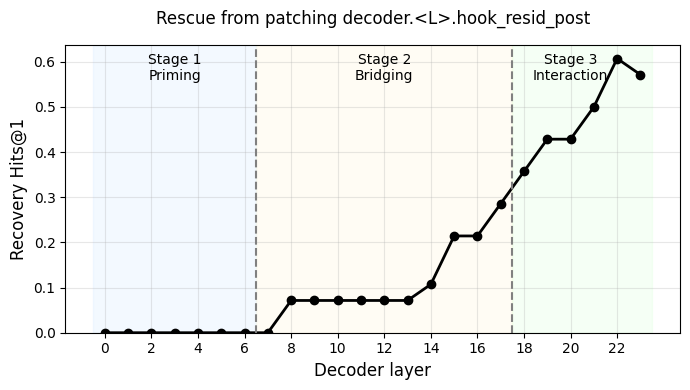

In [8]:
# --- build layer_mean from result_df ---------------------------------
pat = re.compile(r"decoder\.(\d+)\.hook_resid_post")
rows = [
    (int(m.group(1)), r["recovery_hits@1"])
    for _, r in result_df.iterrows()
    if (m := pat.search(r["hook"]))
]
layer_mean = (
    pd.DataFrame(rows, columns=["layer", "score"])
      .groupby("layer")["score"]
      .mean()
      .sort_index()
)

# --- plotting --------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(layer_mean.index, layer_mean.values,
        marker="o", linewidth=2, color="black")

ax.axvspan(-0.5, 6.5,  color="#d0e8ff", alpha=0.25)
ax.axvspan(6.5, 17.5, color="#fff7d5", alpha=0.25)
ax.axvspan(17.5, 23.5, color="#d8ffd8", alpha=0.25)
ax.axvline(6.5,  linestyle="--", color="grey")
ax.axvline(17.5, linestyle="--", color="grey")

ax.text(3,  0.62, "Stage 1\nPriming",     ha="center", va="top", fontsize=10)
ax.text(12, 0.62, "Stage 2\nBridging",    ha="center", va="top", fontsize=10)
ax.text(20, 0.62, "Stage 3\nInteraction", ha="center", va="top", fontsize=10)

ax.set_xlabel("Decoder layer", fontsize=12)
ax.set_ylabel("Recovery Hits@1", fontsize=12)
ax.set_title("Rescue from patching decoder.<L>.hook_resid_post",
             fontsize=12, pad=15)
ax.set_ylim(0, layer_mean.max()*1.05)
ax.set_xticks(range(0, 24, 2))
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Interpretation
The curve shows how often the missing model is “fixed” after we overwrite `hook_resid_post` at a single layer with the full model’s activation.
Almost no rescue occurs in the **Priming stage** (layers 0-6), only modest gains appear across the **Bridging stage** (7-17), and a steep rise begins at layer 18, peaking around 60 % at layers 22-23 in the **Interaction stage**.
In short, the decisive information the weak model lacks is formed in the last few decoder blocks; earlier layers contribute relatively little to retrieval success.


### `resid_pre` vs. `resid_post`

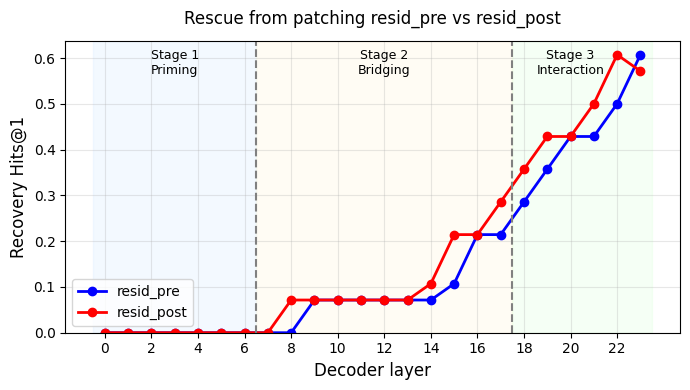

In [ ]:
# ---- build layer_mean_post ----------------------------------------
pat_post = re.compile(r"decoder\.(\d+)\.hook_resid_post")
rows_post = [
    (int(m.group(1)), r["recovery_hits@1"])
    for _, r in result_df.iterrows()
    if (m := pat_post.search(r["hook"]))
]
layer_mean_post = (
    pd.DataFrame(rows_post, columns=["layer", "score"])
      .groupby("layer")["score"]
      .mean()
      .sort_index()
)

# ---- build layer_mean_pre -----------------------------------------
pat_pre = re.compile(r"decoder\.(\d+)\.hook_resid_pre")
rows_pre = [
    (int(m.group(1)), r["recovery_hits@1"])
    for _, r in result_df.iterrows()
    if (m := pat_pre.search(r["hook"]))
]
layer_mean_pre = (
    pd.DataFrame(rows_pre, columns=["layer", "score"])
      .groupby("layer")["score"]
      .mean()
      .sort_index()
)

# ---- plotting ------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4))

# plot the two curves
ax.plot(layer_mean_pre.index, layer_mean_pre.values,
        marker="o", linewidth=2, color="blue",  label="resid_pre")
ax.plot(layer_mean_post.index, layer_mean_post.values,
        marker="o", linewidth=2, color="red",   label="resid_post")

# stage shading
ax.axvspan(-0.5, 6.5,  color="#d0e8ff", alpha=0.25)
ax.axvspan(6.5, 17.5, color="#fff7d5", alpha=0.25)
ax.axvspan(17.5, 23.5, color="#d8ffd8", alpha=0.25)
ax.axvline(6.5,  linestyle="--", color="grey")
ax.axvline(17.5, linestyle="--", color="grey")

# stage labels
y_top = max(layer_mean_post.max(), layer_mean_pre.max()) * 1.02
ax.text(3,  y_top, "Stage 1\nPriming",     ha="center", va="top", fontsize=9)
ax.text(12, y_top, "Stage 2\nBridging",    ha="center", va="top", fontsize=9)
ax.text(20, y_top, "Stage 3\nInteraction", ha="center", va="top", fontsize=9)

ax.set_xlabel("Decoder layer", fontsize=12)
ax.set_ylabel("Recovery Hits@1", fontsize=12)
ax.set_title("Rescue from patching resid_pre vs resid_post", fontsize=12, pad=12)
ax.set_ylim(0, y_top * 1.03)
ax.set_xticks(range(0, 24, 2))
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()


### Interpretation
Comparing the two curves shows that simply giving the missing model the **correct input** to each late decoder layer (`resid_pre`) already fixes most of its failures, while supplying the **full output** of the layer (`resid_post`) yields a slightly higher rescue. This tells us the decisive retrieval signal is present at the entrance to the Interaction layers (18-23); the sub-blocks inside those layers in the missing model can refine—but not fully recreate—that signal. Earlier layers (0-17) contribute little, confirming that the performance gap is localized to the top of the decoder rather than being distributed throughout the stack.


Note: the slight drop at layer-23 occurs because patching **`decoder.23.hook_resid_post`** skips the missing model’s entire final block, feeding the full-model vector directly into the **missing model’s output head**. Layer-23 in the full model is tuned to work with its **own** projection head, so its residual vector no longer matches the under-trained head perfectly—costing a few correct hits. Patching one layer earlier (layer 22) still lets the missing model’s own layer 23 adapt the imported signal to its head, giving the peak rescue score; going past that point re-introduces a small mismatch and the curve dips.


### Next Step: Aggregate Hooks by Layer

Whole-layer sweep: 100%|██████████| 24/24 [01:03<00:00,  2.63s/it]


    layer    hits@1
0       0  0.000000
1       1  0.000000
2       2  0.000000
3       3  0.000000
4       4  0.000000
5       5  0.000000
6       6  0.000000
7       7  0.000000
8       8  0.071429
9       9  0.071429
10     10  0.071429
11     11  0.071429
12     12  0.071429
13     13  0.071429
14     14  0.107143
15     15  0.214286
16     16  0.214286
17     17  0.285714
18     18  0.357143
19     19  0.428571
20     20  0.428571
21     21  0.500000
22     22  0.607143
23     23  0.571429


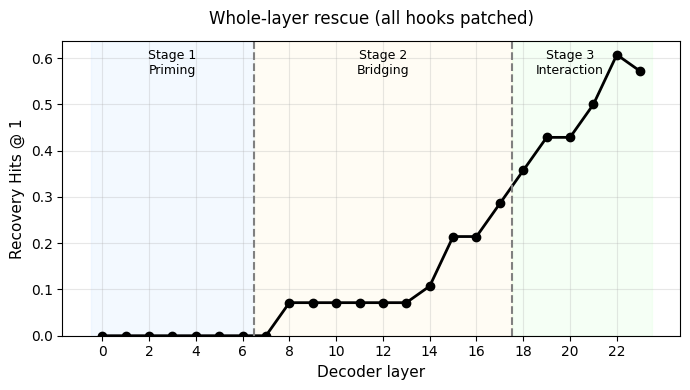

In [ ]:
LAYER_HOOKS = {
    "attn"      : "decoder.{L}.hook_attn_out",
    "xattn"     : "decoder.{L}.hook_cross_attn_out",   # decoder-only
    "mlp"       : "decoder.{L}.hook_mlp_out",
    "resid_pre" : "decoder.{L}.hook_resid_pre",
    "resid_mid" : "decoder.{L}.hook_resid_mid",
    "resid_mid_cross" : "decoder.{L}.hook_resid_mid_cross",
    "resid_post": "decoder.{L}.hook_resid_post",
}

def run_layer_patched(missing_model, layer_idx, qid_list):
    """Return dict{qid: top-k decoded doc IDs} with one-layer patch active."""
    hooks = []
    for template in LAYER_HOOKS.values():
        hook_name = template.format(L=layer_idx)
        if hook_name not in missing_model.hook_dict:
            continue         # skip e.g. cross-attn in encoder
        def make_patch(src):
            return lambda dst, hook, src=src: dst.copy_(src)
        hooks.append( (hook_name, make_patch) )
    
    results = {}
    for qid in tqdm(qid_list, desc=f"Layer {layer_idx:02d}", leave=False):
        # generate one dict entry per query
        src_cache = full_cache[qid]
        local_hooks = [
            (hname, make_patch(src_cache[hname].detach()))
            for hname, make_patch in hooks
        ]
        logits = missing_model.run_with_hooks(
            enc(next(q["query"] for q in test_queries if q["id"] == qid)),
            decoder_input,
            fwd_hooks=local_hooks
        )
        results[qid] = ranked_docs(logits, k=TOPK_THRESHOLD)
    return results

layer_scores = []
for L in tqdm(range(24), desc="Whole-layer sweep"):
    patched_run = run_layer_patched(model_missing, L, hard_qids)
    score = metrics(patched_run)["hits@1"]
    layer_scores.append({"layer": L, "hits@1": score})
layer_df = pd.DataFrame(layer_scores)
print(layer_df)

# --- Plotting the whole-layer rescue results --------------------------
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(layer_df["layer"], layer_df["hits@1"],
        marker="o", linewidth=2, color="black")

# stage shading: 0-6 (Priming), 7-17 (Bridging), 18-23 (Interaction)
ax.axvspan(-0.5,  6.5, color="#d0e8ff", alpha=0.25)
ax.axvspan( 6.5, 17.5, color="#fff7d5", alpha=0.25)
ax.axvspan(17.5, 23.5, color="#d8ffd8", alpha=0.25)
ax.axvline(6.5,  linestyle="--", color="grey")
ax.axvline(17.5, linestyle="--", color="grey")

# stage labels inside coloured bands
ax.text( 3,  layer_df["hits@1"].max()*1.02, "Stage 1\nPriming",
        ha="center", va="top", fontsize=9)
ax.text(12,  layer_df["hits@1"].max()*1.02, "Stage 2\nBridging",
        ha="center", va="top", fontsize=9)
ax.text(20,  layer_df["hits@1"].max()*1.02, "Stage 3\nInteraction",
        ha="center", va="top", fontsize=9)

ax.set_xlabel("Decoder layer", fontsize=11)
ax.set_ylabel("Recovery Hits @ 1", fontsize=11)
ax.set_title("Whole-layer rescue (all hooks patched)", fontsize=12, pad=12)
ax.set_ylim(0, layer_df["hits@1"].max()*1.05)
ax.set_xticks(range(0, 24, 2))
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Conclusion from the whole-layer patching test

Copying every activation produced by a decoder layer (self-attention, cross-attention, MLP, and all residual checkpoints) rescues the missing model **no more than copying just that layer’s final `resid_post` vector**.
This shows that:

* The decisive retrieval information is already fully captured in the layer’s final residual stream.
* Faulty intermediate outputs inside the layer do not add extra damage once the correct residual is supplied.
* Therefore, to fix the under-trained model it is enough to transplant the `resid_post` of the late “Interaction” layers (18-23); replacing earlier sub-block outputs brings no additional benefit.


### Component patching
We also experimented with patching individual MLP blocks, cross-attention and self-attention, but these attempts did not improve performance. Although not reported in the paper, we include them here to document that such directions were explored.

MLP-only sweep: 100%|██████████| 24/24 [00:56<00:00,  2.37s/it]


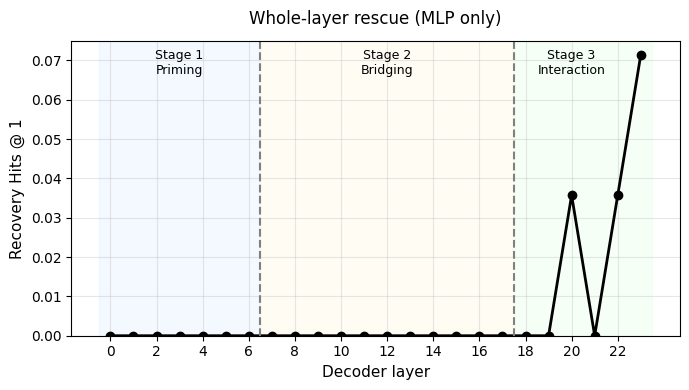

In [8]:
# ---------------------------------------------------------------------
# 1.  Hook template (MLP only)
# ---------------------------------------------------------------------
MLP_HOOK_TPL = "decoder.{L}.hook_mlp_out"   # we will patch just this one

# ---------------------------------------------------------------------
# 2.  Helper: patch a single layer’s MLP and evaluate
# ---------------------------------------------------------------------
def run_layer_patched(missing_model, full_cache, layer_idx, qids):
    """
    Patch decoder.{layer_idx}.hook_mlp_out with activations from the full model
    and return {qid: top-k docs} for the given query IDs.
    """
    hook_name = MLP_HOOK_TPL.format(L=layer_idx)
    if hook_name not in missing_model.hook_dict:
        return {}  # layer doesn’t have that hook (shouldn’t happen on decoder)

    def builder(src):
        return lambda dst, hook, src=src: dst.copy_(src)

    results = {}
    for qid in tqdm(qids, desc=f"L{layer_idx:02d}", leave=False):
        src_cache = full_cache[qid]
        if hook_name not in src_cache:
            continue  # safety guard

        logits = missing_model.run_with_hooks(
            enc(next(q["query"] for q in test_queries if q["id"] == qid)),
            decoder_input,
            fwd_hooks=[(hook_name, builder(src_cache[hook_name].detach()))],
        )
        results[qid] = ranked_docs(logits, k=TOPK_THRESHOLD)
    return results

# ---------------------------------------------------------------------
# 3.  Run sweep over all 24 decoder layers
# ---------------------------------------------------------------------
layer_scores = []
for L in tqdm(range(24), desc="MLP-only sweep"):
    patched = run_layer_patched(model_missing, full_cache, L, hard_qids)
    layer_scores.append({"layer": L, "hits@1": metrics(patched).get("hits@1", 0.0)})

layer_df = pd.DataFrame(layer_scores)

# ---------------------------------------------------------------------
# 4.  Plot
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(layer_df["layer"], layer_df["hits@1"],
        marker="o", linewidth=2, color="black")

# Stage shading (optional cosmetic)
ax.axvspan(-0.5,  6.5, color="#d0e8ff", alpha=0.25)
ax.axvspan( 6.5, 17.5, color="#fff7d5", alpha=0.25)
ax.axvspan(17.5, 23.5, color="#d8ffd8", alpha=0.25)
ax.axvline(6.5,  linestyle="--", color="grey")
ax.axvline(17.5, linestyle="--", color="grey")

# Stage labels
peak = layer_df["hits@1"].max()
ax.text( 3, peak*1.02, "Stage 1\nPriming",     ha="center", va="top", fontsize=9)
ax.text(12, peak*1.02, "Stage 2\nBridging",    ha="center", va="top", fontsize=9)
ax.text(20, peak*1.02, "Stage 3\nInteraction", ha="center", va="top", fontsize=9)

ax.set_xlabel("Decoder layer", fontsize=11)
ax.set_ylabel("Recovery Hits @ 1", fontsize=11)
ax.set_title("Whole-layer rescue (MLP only)", fontsize=12, pad=12)
ax.set_ylim(0, peak*1.05)
ax.set_xticks(range(0, 24, 2))
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Attn-only sweep: 100%|██████████| 24/24 [00:59<00:00,  2.46s/it]
/tmp/ipykernel_1495368/573613565.py:68: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, peak*1.05)


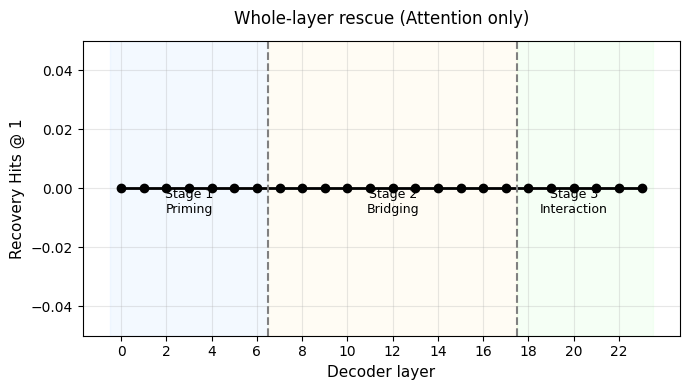

In [9]:
# ---------------------------------------------------------------------
# 1. Hook template for attention output
# ---------------------------------------------------------------------
ATTN_HOOK_TPL = "decoder.{L}.hook_attn_out"   # attention output hook

# ---------------------------------------------------------------------
# 2. Helper: patch a single layer’s attention output
# ---------------------------------------------------------------------
def run_layer_attn_patched(missing_model, full_cache, layer_idx, qids):
    """
    Patch decoder.{layer_idx}.hook_attn_out from the full model,
    return {qid: top-k doc IDs} after patching that hook only.
    """
    hook_name = ATTN_HOOK_TPL.format(L=layer_idx)
    if hook_name not in missing_model.hook_dict:
        return {}

    def builder(src):
        return lambda dst, hook, src=src: dst.copy_(src)

    results = {}
    for qid in tqdm(qids, desc=f"Attn L{layer_idx:02d}", leave=False):
        src_cache = full_cache.get(qid, {})
        if hook_name not in src_cache:
            continue

        logits = missing_model.run_with_hooks(
            enc(next(q["query"] for q in test_queries if q["id"] == qid)),
            decoder_input,
            fwd_hooks=[(hook_name, builder(src_cache[hook_name].detach()))],
        )
        results[qid] = ranked_docs(logits, k=TOPK_THRESHOLD)
    return results

# ---------------------------------------------------------------------
# 3. Run sweep over all 24 decoder layers
# ---------------------------------------------------------------------
attn_scores = []
for L in tqdm(range(24), desc="Attn-only sweep"):
    patched = run_layer_attn_patched(model_missing, full_cache, L, hard_qids)
    attn_scores.append({"layer": L, "hits@1": metrics(patched).get("hits@1", 0.0)})

attn_df = pd.DataFrame(attn_scores)

# ---------------------------------------------------------------------
# 4. Plot the results
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(attn_df["layer"], attn_df["hits@1"],
        marker="o", linewidth=2, color="black")

# Stage shading
ax.axvspan(-0.5,  6.5, color="#d0e8ff", alpha=0.25)
ax.axvspan( 6.5, 17.5, color="#fff7d5", alpha=0.25)
ax.axvspan(17.5, 23.5, color="#d8ffd8", alpha=0.25)
ax.axvline(6.5,  linestyle="--", color="grey")
ax.axvline(17.5, linestyle="--", color="grey")

# Labels
peak = attn_df["hits@1"].max()
ax.text( 3,  peak*1.02, "Stage 1\nPriming",     ha="center", va="top", fontsize=9)
ax.text(12, peak*1.02, "Stage 2\nBridging",    ha="center", va="top", fontsize=9)
ax.text(20, peak*1.02, "Stage 3\nInteraction", ha="center", va="top", fontsize=9)

ax.set_xlabel("Decoder layer", fontsize=11)
ax.set_ylabel("Recovery Hits @ 1", fontsize=11)
ax.set_title("Whole-layer rescue (Attention only)", fontsize=12, pad=12)
ax.set_ylim(0, peak*1.05)
ax.set_xticks(range(0, 24, 2))
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


XAttn-only sweep: 100%|██████████| 24/24 [00:57<00:00,  2.38s/it]


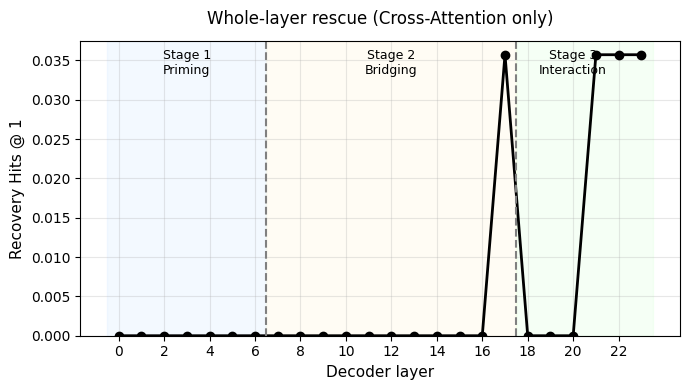

In [10]:
# ---------------------------------------------------------------------
# 1. Hook template for cross-attention output
# ---------------------------------------------------------------------
XATTN_HOOK_TPL = "decoder.{L}.hook_cross_attn_out"

# ---------------------------------------------------------------------
# 2. Helper: patch a single layer’s cross-attn output
# ---------------------------------------------------------------------
def run_layer_xattn_patched(missing_model, full_cache, layer_idx, qids):
    """
    Patch decoder.{layer_idx}.hook_cross_attn_out from the full model,
    return {qid: top-k doc IDs} after patching that hook only.
    """
    hook_name = XATTN_HOOK_TPL.format(L=layer_idx)
    if hook_name not in missing_model.hook_dict:
        return {}

    def builder(src):
        return lambda dst, hook, src=src: dst.copy_(src)

    results = {}
    for qid in tqdm(qids, desc=f"XAttn L{layer_idx:02d}", leave=False):
        src_cache = full_cache.get(qid, {})
        if hook_name not in src_cache:
            continue

        logits = missing_model.run_with_hooks(
            enc(next(q["query"] for q in test_queries if q["id"] == qid)),
            decoder_input,
            fwd_hooks=[(hook_name, builder(src_cache[hook_name].detach()))],
        )
        results[qid] = ranked_docs(logits, k=TOPK_THRESHOLD)
    return results

# ---------------------------------------------------------------------
# 3. Run sweep over all 24 decoder layers
# ---------------------------------------------------------------------
xattn_scores = []
for L in tqdm(range(24), desc="XAttn-only sweep"):
    patched = run_layer_xattn_patched(model_missing, full_cache, L, hard_qids)
    xattn_scores.append({"layer": L, "hits@1": metrics(patched).get("hits@1", 0.0)})

xattn_df = pd.DataFrame(xattn_scores)

# ---------------------------------------------------------------------
# 4. Plot results
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(xattn_df["layer"], xattn_df["hits@1"],
        marker="o", linewidth=2, color="black")

# Stage shading
ax.axvspan(-0.5,  6.5, color="#d0e8ff", alpha=0.25)
ax.axvspan( 6.5, 17.5, color="#fff7d5", alpha=0.25)
ax.axvspan(17.5, 23.5, color="#d8ffd8", alpha=0.25)
ax.axvline(6.5,  linestyle="--", color="grey")
ax.axvline(17.5, linestyle="--", color="grey")

# Labels
peak = xattn_df["hits@1"].max()
ax.text( 3,  peak*1.02, "Stage 1\nPriming",     ha="center", va="top", fontsize=9)
ax.text(12, peak*1.02, "Stage 2\nBridging",    ha="center", va="top", fontsize=9)
ax.text(20, peak*1.02, "Stage 3\nInteraction", ha="center", va="top", fontsize=9)

ax.set_xlabel("Decoder layer", fontsize=11)
ax.set_ylabel("Recovery Hits @ 1", fontsize=11)
ax.set_title("Whole-layer rescue (Cross-Attention only)", fontsize=12, pad=12)
ax.set_ylim(0, peak*1.05)
ax.set_xticks(range(0, 24, 2))
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


MLP + XAttn sweep: 100%|██████████| 24/24 [00:57<00:00,  2.38s/it]


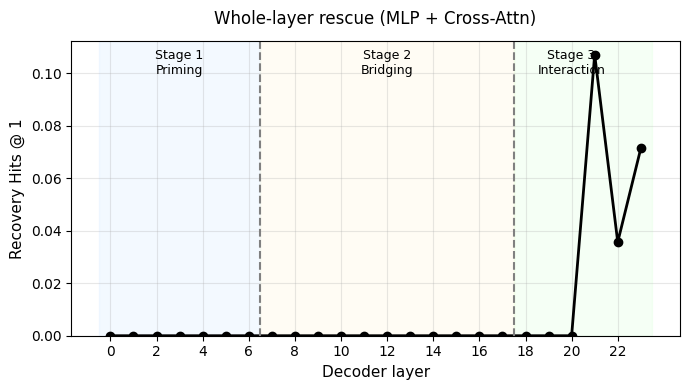

In [11]:
# ---------------------------------------------------------------------
# 1. Hook templates: MLP and cross-attn output
# ---------------------------------------------------------------------
PATCH_HOOKS_TPL = [
    "decoder.{L}.hook_mlp_out",
    "decoder.{L}.hook_cross_attn_out"
]

# ---------------------------------------------------------------------
# 2. Helper function
# ---------------------------------------------------------------------
def run_layer_mlp_xattn_patched(missing_model, full_cache, layer_idx, qids):
    """
    Patch both MLP and cross-attn outputs at decoder layer {layer_idx}
    from the full model. Returns {qid: top-k doc IDs}.
    """
    hook_names = [
        tpl.format(L=layer_idx)
        for tpl in PATCH_HOOKS_TPL
        if tpl.format(L=layer_idx) in missing_model.hook_dict
    ]
    if not hook_names:
        return {}

    def builder(src):
        return lambda dst, hook, src=src: dst.copy_(src)

    results = {}
    for qid in tqdm(qids, desc=f"MLP+XAttn L{layer_idx:02d}", leave=False):
        src_cache = full_cache.get(qid, {})
        local_hooks = [
            (hname, builder(src_cache[hname].detach()))
            for hname in hook_names if hname in src_cache
        ]
        logits = missing_model.run_with_hooks(
            enc(next(q["query"] for q in test_queries if q["id"] == qid)),
            decoder_input,
            fwd_hooks=local_hooks
        )
        results[qid] = ranked_docs(logits, k=TOPK_THRESHOLD)
    return results

# ---------------------------------------------------------------------
# 3. Sweep over all 24 decoder layers
# ---------------------------------------------------------------------
combined_scores = []
for L in tqdm(range(24), desc="MLP + XAttn sweep"):
    patched = run_layer_mlp_xattn_patched(model_missing, full_cache, L, hard_qids)
    combined_scores.append({"layer": L, "hits@1": metrics(patched).get("hits@1", 0.0)})

combined_df = pd.DataFrame(combined_scores)

# ---------------------------------------------------------------------
# 4. Plot
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(combined_df["layer"], combined_df["hits@1"],
        marker="o", linewidth=2, color="black")

# Stage shading
ax.axvspan(-0.5,  6.5, color="#d0e8ff", alpha=0.25)
ax.axvspan( 6.5, 17.5, color="#fff7d5", alpha=0.25)
ax.axvspan(17.5, 23.5, color="#d8ffd8", alpha=0.25)
ax.axvline(6.5,  linestyle="--", color="grey")
ax.axvline(17.5, linestyle="--", color="grey")

# Labels
peak = combined_df["hits@1"].max()
ax.text( 3,  peak*1.02, "Stage 1\nPriming",     ha="center", va="top", fontsize=9)
ax.text(12, peak*1.02, "Stage 2\nBridging",    ha="center", va="top", fontsize=9)
ax.text(20, peak*1.02, "Stage 3\nInteraction", ha="center", va="top", fontsize=9)

ax.set_xlabel("Decoder layer", fontsize=11)
ax.set_ylabel("Recovery Hits @ 1", fontsize=11)
ax.set_title("Whole-layer rescue (MLP + Cross-Attn)", fontsize=12, pad=12)
ax.set_ylim(0, peak*1.05)
ax.set_xticks(range(0, 24, 2))
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Multi-Layer Patching
The following cell was used to achieve the results presented in the corresponding section of the paper. 

In [ ]:
def run_multi_layer_mlp_xattn_patch(model, full_cache, qids, layers=(20, 21, 22, 23)):
    """
    Apply multi-layer patching of both MLP and cross-attention outputs.

    For each query ID, cached activations from a "full" model run are patched
    into the specified layers of the missing model. Both MLP outputs and
    cross-attention outputs are patched. The model is then run to obtain
    predictions, and the top-1 document is recorded.

    Parameters
    ----------
    model : HookedTransformer or compatible
        The model to patch, supporting `run_with_hooks`.
    full_cache : dict
        Dictionary mapping query IDs (str) to cached activations from the
        full model, used as the patch source.
    qids : list of str
        Query identifiers to evaluate.
    layers : tuple of int, optional
        Decoder layers to patch (default = (20, 21, 22, 23)).

    Returns
    -------
    dict
        Mapping from query ID (str) to the top-1 retrieved document (str).
    """
    # Collect names of hook points to patch (MLP and cross-attention outputs).
    hook_names = []
    for L in layers:
        for tpl in ["decoder.{L}.hook_mlp_out", "decoder.{L}.hook_cross_attn_out"]:
            name = tpl.format(L=L)
            if name in model.hook_dict:
                hook_names.append(name)

    # Hook builder: copies cached activations into target layer during forward pass.
    def builder(src):
        return lambda dst, hook, src=src: dst.copy_(src)

    recovered = {}
    for qid in tqdm(qids, desc="Patching L20–23 (mlp + xattn)"):
        src_cache = full_cache[qid]

        # Build local hooks for all requested layers available in the cache.
        local_hooks = [
            (h, builder(src_cache[h].detach()))
            for h in hook_names if h in src_cache
        ]

        # Run patched model forward pass.
        logits = model.run_with_hooks(
            enc(next(q["query"] for q in test_queries if q["id"] == qid)),
            decoder_input,
            fwd_hooks=local_hooks
        )

        # Record the top-1 predicted document.
        recovered[qid] = ranked_docs(logits, k=1)[0]

    return recovered


# --- Run and compute recovery
recovered_outputs = run_multi_layer_mlp_xattn_patch(model_missing, full_cache, hard_qids)
recovered_count = sum(recovered_outputs[qid] in relevant_for_query[qid] for qid in hard_qids)
recovered_percent = recovered_count / len(hard_qids) * 100

print(f"Recovered {recovered_count} out of {len(hard_qids)} hard queries "
      f"using MLP + cross-attn patching on layers 20–23")
print(f"Recovery Hits@1: {recovered_percent:.2f}%")


Patching L20–23 (mlp + xattn): 100%|██████████| 28/28 [00:02<00:00, 11.81it/s]

Recovered 11 out of 28 hard queries using MLP + cross-attn patching on layers 20–23
Recovery Hits@1: 39.29%


## Comparing Several Missing Models

## Setup (similar pipeline)

In [1]:
import torch
from tqdm import tqdm
import json
from transformer_lens import HookedEncoderDecoder
from transformer_lens.hook_points import HookPoint
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from collections import defaultdict
import os
import pandas as pd
import logging
import re
import matplotlib.pyplot as plt
import pickle

logging.getLogger().setLevel(logging.ERROR)

# === CONFIGURATION ===
FULL_MODEL_PATH    = "../../models/DSI-large-7423"
MISSING_MODEL_PATH = "../../models/checkpoint-50000"
MISSING_MODEL_2_PATH = "../../models/checkpoint-40000"
MISSING_MODEL_3_PATH = "../../models/checkpoint-60000"
TEST_QUERY_PATH    = "../../NQ10k/test_queries-10000-7423.json"
QRELS_PATH         = "../../output/atomic/1/test_qrels.json" #generated by preprocess.py
TOPK_THRESHOLD     = 10
DEVICE             = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
hf_full      = AutoModelForSeq2SeqLM.from_pretrained(FULL_MODEL_PATH).to(DEVICE)
hf_missing   = AutoModelForSeq2SeqLM.from_pretrained(MISSING_MODEL_PATH).to(DEVICE)
hf_missing_2 = AutoModelForSeq2SeqLM.from_pretrained(MISSING_MODEL_2_PATH).to(DEVICE)
hf_missing_3 = AutoModelForSeq2SeqLM.from_pretrained(MISSING_MODEL_3_PATH).to(DEVICE)

model_full      = HookedEncoderDecoder.from_pretrained(FULL_MODEL_PATH,      hf_model=hf_full,      device=DEVICE).eval()
model_missing   = HookedEncoderDecoder.from_pretrained(MISSING_MODEL_PATH,   hf_model=hf_missing,   device=DEVICE).eval()
model_missing_2 = HookedEncoderDecoder.from_pretrained(MISSING_MODEL_2_PATH, hf_model=hf_missing_2, device=DEVICE).eval()
model_missing_3 = HookedEncoderDecoder.from_pretrained(MISSING_MODEL_3_PATH, hf_model=hf_missing_3, device=DEVICE).eval()

tokenizer    = AutoTokenizer.from_pretrained(FULL_MODEL_PATH)

decoder_input = torch.tensor([[tokenizer.pad_token_id]]).to(DEVICE)

Moving model to device:  cuda
Loaded pretrained model ../../models/DSI-large-7423 into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model ../../models/checkpoint-50000 into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model ../../models/checkpoint-40000 into HookedTransformer
Moving model to device:  cuda
Loaded pretrained model ../../models/checkpoint-60000 into HookedTransformer


In [3]:
with open(TEST_QUERY_PATH) as f:
    test_queries = json.load(f)
with open(QRELS_PATH) as f:
    qrels_json = json.load(f)

# Map query → list[docid]
relevant_for_query = defaultdict(list)
for qid, doc in zip(qrels_json["query"], qrels_json["docid"]):
    relevant_for_query[qid].append(str(doc))

max_len = max(len(tokenizer.tokenize(q["query"])) for q in test_queries) + 1

def enc(query):
    return tokenizer(query, return_tensors="pt", padding="max_length", max_length=max_len)["input_ids"].to(DEVICE)

In [4]:
def ranked_docs(logits, k=TOPK_THRESHOLD):
    """Return list[str] of top‑k decoded tokens for first decoder position."""
    idx = logits.topk(k, dim=-1).indices[0, 0].tolist()
    return [tokenizer.decode(i) for i in idx]

def run_model(model, queries):
    results = {}
    for q in queries:
        ids = enc(q["query"])
        logits, _ = model.run_with_cache(ids, decoder_input, remove_batch_dim=True)
        results[q["id"]] = ranked_docs(logits, k=TOPK_THRESHOLD)
    return results

def metrics(run):
    """Compute Hits@1 / Recall@5 / Hits@10 for a dict qid -> list[docid]."""
    hits1 = hits10 = 0
    recall5_sum = 0
    for qid, ranked in run.items():
        rels = relevant_for_query[qid]
        # Hits@1
        if ranked and ranked[0] in rels:
            hits1 += 1
        # Hits@10
        if any(doc in rels for doc in ranked[:10]):
            hits10 += 1
        # Recall@5
        recall5_sum += sum(doc in rels for doc in ranked[:5]) / max(1, len(rels))
    n = len(run)
    return {
        "hits@1":  hits1 / n,
        "hits@10": hits10 / n,
        "recall@5": recall5_sum / n,
    }

## Pre-Patching Analysis

### Baseline Performance

In [5]:
full_base    = run_model(model_full,    test_queries)
missing_base = run_model(model_missing, test_queries)
missing_base_2 = run_model(model_missing_2, test_queries)
missing_base_3 = run_model(model_missing_3, test_queries)   

print("Full model:",    metrics(full_base))
print("Missing model:", metrics(missing_base))
print("Missing model 2:", metrics(missing_base_2))
print("Missing model 3:", metrics(missing_base_3))

# Identify hard queries (full correct @1, missing wrong @10)
hard_qids = [q["id"] for q in test_queries if full_base[q["id"]][0] in relevant_for_query[q["id"]] and not any(doc in relevant_for_query[q["id"]] for doc in missing_base[q["id"]][:10])]
print(f"Hard queries for missing model: {len(hard_qids)}")

hard_qids_2 = [q["id"] for q in test_queries if full_base[q["id"]][0] in relevant_for_query[q["id"]] and not any(doc in relevant_for_query[q["id"]] for doc in missing_base_2[q["id"]][:10])]
print(f"Hard queries for missing model 2: {len(hard_qids_2)}")

hard_qids_3 = [q["id"] for q in test_queries if full_base[q["id"]][0] in relevant_for_query[q["id"]] and not any(doc in relevant_for_query[q["id"]] for doc in missing_base_3[q["id"]][:10])]
print(f"Hard queries for missing model 3: {len(hard_qids_3)}")

Full model: {'hits@1': 0.405, 'hits@10': 0.638, 'recall@5': 0.581}
Missing model: {'hits@1': 0.394, 'hits@10': 0.623, 'recall@5': 0.569}
Missing model 2: {'hits@1': 0.397, 'hits@10': 0.63, 'recall@5': 0.569}
Missing model 3: {'hits@1': 0.389, 'hits@10': 0.639, 'recall@5': 0.578}
Hard queries for missing model: 28
Hard queries for missing model 2: 27
Hard queries for missing model 3: 18


### Top-relevant document for each hard query - for later exploration with embedding models

In [6]:
def print_top_relevant_docs(hard_qids, name):
    print(f"\n{name} — Top relevant doc for each hard query:\n" + "-"*50)
    for qid in hard_qids:
        top_rel_doc = relevant_for_query[qid][0] if relevant_for_query[qid] else "N/A"
        print(f"{top_rel_doc}")

# Print for each model
print_top_relevant_docs(hard_qids,   "Missing Model 1")
print_top_relevant_docs(hard_qids_2, "Missing Model 2")
print_top_relevant_docs(hard_qids_3, "Missing Model 3")



Missing Model 1 — Top relevant doc for each hard query:
--------------------------------------------------
@DOC_ID_-5402697853033680631@
@DOC_ID_4399912168528695468@
@DOC_ID_-79356518927071838@
@DOC_ID_818002923934435137@
@DOC_ID_-1979784142726159894@
@DOC_ID_1935832950700823@
@DOC_ID_-5944168583179757903@
@DOC_ID_-6506210663137335822@
@DOC_ID_-5571676562943073320@
@DOC_ID_2503275827954984607@
@DOC_ID_5019280356001369026@
@DOC_ID_-2654989306076235475@
@DOC_ID_5396601880652018781@
@DOC_ID_-3060307639232891656@
@DOC_ID_5480436824826220839@
@DOC_ID_678930299284183680@
@DOC_ID_1679657142367725037@
@DOC_ID_8613324768723804912@
@DOC_ID_8193895603691109728@
@DOC_ID_-9094405453475162500@
@DOC_ID_-3831876897414116630@
@DOC_ID_9102960224409812839@
@DOC_ID_3012568508229512715@
@DOC_ID_6728482020797819238@
@DOC_ID_3384693042822879189@
@DOC_ID_7996704291881509357@
@DOC_ID_5864021829043396331@
@DOC_ID_-2928116638358297228@

Missing Model 2 — Top relevant doc for each hard query:
-------------------

### Print out unique hard quieries for each missing model

In [7]:
# Create a mapping from query ID to query string
qid_to_query = {q["id"]: q["query"] for q in test_queries}

# Convert hard qids to sets
hard_1 = set(hard_qids)
hard_2 = set(hard_qids_2)
hard_3 = set(hard_qids_3)

# Compute unique hard query IDs per model
unique_1 = hard_1 - (hard_2 | hard_3)
unique_2 = hard_2 - (hard_1 | hard_3)
unique_3 = hard_3 - (hard_1 | hard_2)

# Print all actual query strings for each unique hard set
print(f"Unique hard queries for missing_base      : {len(unique_1)}")
for qid in sorted(unique_1):
    print(f"- {qid_to_query[qid]}")
print()

print(f"Unique hard queries for missing_base_2    : {len(unique_2)}")
for qid in sorted(unique_2):
    print(f"- {qid_to_query[qid]}")
print()

print(f"Unique hard queries for missing_base_3    : {len(unique_3)}")
for qid in sorted(unique_3):
    print(f"- {qid_to_query[qid]}")
print()


Unique hard queries for missing_base      : 15
- when does the next episode of izombie air
- who does the uk have extradition treaties with
- what do the stars on the dc flag mean
- when was the japanese videogame company nintendo founded
- when did the age of new media began
- what are the importance of rigor mortis in meat processing
- central idea of poem lines from the deserted village
- what is the sign of greater and less than
- what is the song who are you by the who about
- who did the music for your lie in april
- when was the last time tug-of-war was an official olympic sport
- cox's bazar the longest beach in the world
- how does the romanesque bust reliquary reflect another culture's influence
- what is the origin of the name robinson
- what are the advantages or disadvantages of using pure tones in auditory research

Unique hard queries for missing_base_2    : 16
- is president's day a bank holiday in the us
- where does the boston post road start and end
- is there a 4th 

### Interpretation
The distribution of unique hard queries across the missing models—each trained on 10 fewer documents — reveals that different types of knowledge are unevenly affected by missing document exposure. While the full model handles all queries well, each missing model struggles with a distinct subset: 
- `missing_base` fails on symbolic and historical questions, 
- `missing_base_2` on geographic and entity-based facts, and
- `missing_base_3` mostly on pop culture.

## Patching Experiments
We begin by replacing internal activations in the missing model with those from the full model at specific hooks. This allows us to measure how much retrieval performance is recovered by each patch point.<br>
We measure retrieval recovery using **Hits\@1** on hard queries — the proportion of cases where the *patched* missing model ranks a relevant document first, compared to its original failure. This quantifies how much the patch restores correct retrieval behavior.
* This time we wrapped it in a function :)


In [8]:
def run_activation_patching(
    model_full, 
    model_missing, 
    test_queries, 
    hard_qids, 
    relevant_for_query, 
    decoder_input, 
    enc, 
    ranked_docs,
    experiment_name="exp1",
    cache_dir="activation_cache",
    verbose=True,
):
    os.makedirs(cache_dir, exist_ok=True)
    full_cache_path = os.path.join(cache_dir, f"full_cache_{experiment_name}.pkl")
    result_path     = os.path.join(cache_dir, f"result_df_{experiment_name}.csv")

    # --- Step 1: Load or compute full_cache ---
    if os.path.exists(full_cache_path):
        if verbose: print(f"Loading full_cache_{experiment_name} from disk...")
        with open(full_cache_path, "rb") as f:
            full_cache = pickle.load(f)
    else:
        if verbose: print(f"Running and saving full_cache_{experiment_name}...")
        full_cache = {}
        for q in tqdm(test_queries, desc=f"Caching full acts {experiment_name}"):
            if q["id"] not in hard_qids:
                continue
            logits, cache = model_full.run_with_cache(enc(q["query"]), decoder_input, remove_batch_dim=True)
            full_cache[q["id"]] = cache
        with open(full_cache_path, "wb") as f:
            pickle.dump(full_cache, f)

    # --- Step 2: Load or compute result_df ---
    if os.path.exists(result_path):
        if verbose: print(f"Loading result_df_{experiment_name} from disk...")
        result_df = pd.read_csv(result_path)
    else:
        if verbose: print(f"Running activation patching {experiment_name}...")
        sample_qid = next(iter(full_cache))
        cached_names = set(full_cache[sample_qid].keys())

        hooks_to_test = [
            h for h in model_missing.hook_dict.keys()
            if h.startswith("decoder.") and h in cached_names
        ]

        results = []
        for hook_name in tqdm(hooks_to_test, desc=f"Patching {experiment_name}"):
            recovered = {}
            for qid in hard_qids:
                src_act = full_cache[qid][hook_name].detach()

                def patch_fn(dst_act, hook, src_act=src_act):
                    dst_act.copy_(src_act)
                    return dst_act

                logits = model_missing.run_with_hooks(
                    enc(next(q["query"] for q in test_queries if q["id"] == qid)),
                    decoder_input,
                    fwd_hooks=[(hook_name, patch_fn)]
                )
                recovered[qid] = ranked_docs(logits, k=1)[0]

            hit = sum(recovered[qid] in relevant_for_query[qid] for qid in hard_qids) / len(hard_qids)
            results.append({"hook": hook_name, "recovery_hits@1": hit})

        result_df = pd.DataFrame(results).sort_values("recovery_hits@1", ascending=False)
        result_df.to_csv(result_path, index=False)

    if verbose:
        print(result_df.head(50))
    return result_df


In [9]:
df1 = run_activation_patching(
    model_full=model_full,
    model_missing=model_missing,
    test_queries=test_queries,
    hard_qids=hard_qids,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    experiment_name="Patching Missing Model 1"
)

Loading full_cache_Patching Missing Model 1 from disk...


Loading result_df_Patching Missing Model 1 from disk...
                               hook  recovery_hits@1
0         decoder.23.hook_resid_mid         0.607143
1         decoder.23.hook_resid_pre         0.607143
2        decoder.22.hook_resid_post         0.607143
3        decoder.23.hook_resid_post         0.571429
4         decoder.22.hook_resid_mid         0.571429
5   decoder.23.hook_resid_mid_cross         0.535714
6   decoder.22.hook_resid_mid_cross         0.535714
7         decoder.22.hook_resid_pre         0.500000
8        decoder.21.hook_resid_post         0.500000
9         decoder.21.hook_resid_mid         0.500000
10  decoder.20.hook_resid_mid_cross         0.464286
11       decoder.19.hook_resid_post         0.428571
12        decoder.20.hook_resid_pre         0.428571
13        decoder.20.hook_resid_mid         0.428571
14       decoder.20.hook_resid_post         0.428571
15  decoder.21.hook_resid_mid_cross         0.428571
16        decoder.21.hook_resid_pre        

In [10]:
df2 = run_activation_patching(
    model_full=model_full,
    model_missing=model_missing_2,
    test_queries=test_queries,
    hard_qids=hard_qids_2,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    experiment_name="Patching Missing Model 2"
)

Loading full_cache_Patching Missing Model 2 from disk...


Loading result_df_Patching Missing Model 2 from disk...
                               hook  recovery_hits@1
0   decoder.23.hook_resid_mid_cross         0.259259
1         decoder.20.hook_resid_pre         0.222222
2        decoder.23.hook_resid_post         0.222222
3         decoder.22.hook_resid_mid         0.222222
4        decoder.19.hook_resid_post         0.222222
5        decoder.20.hook_resid_post         0.185185
6   decoder.20.hook_resid_mid_cross         0.185185
7         decoder.21.hook_resid_pre         0.185185
8   decoder.21.hook_resid_mid_cross         0.185185
9         decoder.21.hook_resid_mid         0.185185
10       decoder.21.hook_resid_post         0.185185
11  decoder.19.hook_resid_mid_cross         0.185185
12  decoder.22.hook_resid_mid_cross         0.185185
13        decoder.22.hook_resid_pre         0.185185
14       decoder.22.hook_resid_post         0.185185
15        decoder.23.hook_resid_pre         0.185185
16        decoder.20.hook_resid_mid        

In [11]:
df3 = run_activation_patching(
    model_full=model_full,
    model_missing=model_missing_3,
    test_queries=test_queries,
    hard_qids=hard_qids_3,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    experiment_name="Patching Missing Model 3"
)

Loading full_cache_Patching Missing Model 3 from disk...


Loading result_df_Patching Missing Model 3 from disk...
                               hook  recovery_hits@1
0        decoder.19.hook_resid_post         0.388889
1         decoder.20.hook_resid_pre         0.388889
2        decoder.23.hook_resid_post         0.388889
3         decoder.20.hook_resid_mid         0.388889
4         decoder.22.hook_resid_mid         0.388889
5         decoder.22.hook_resid_pre         0.388889
6        decoder.21.hook_resid_post         0.388889
7   decoder.21.hook_resid_mid_cross         0.388889
8   decoder.20.hook_resid_mid_cross         0.333333
9   decoder.18.hook_resid_mid_cross         0.333333
10        decoder.19.hook_resid_pre         0.333333
11  decoder.19.hook_resid_mid_cross         0.333333
12       decoder.18.hook_resid_post         0.333333
13  decoder.23.hook_resid_mid_cross         0.333333
14        decoder.19.hook_resid_mid         0.333333
15        decoder.18.hook_resid_mid         0.277778
16        decoder.18.hook_resid_pre        

#### Plotting all 3 missing models

In [ ]:
def extract_layer_scores(df):
    pat = re.compile(r"decoder\.(\d+)\.hook_resid_post")
    rows = [
        (int(m.group(1)), r["recovery_hits@1"])
        for _, r in df.iterrows()
        if (m := pat.search(r["hook"]))
    ]
    return (
        pd.DataFrame(rows, columns=["layer", "score"])
          .groupby("layer")["score"]
          .mean()
          .sort_index()
    )

# Get per-layer average scores for each model
layer_full_1 = extract_layer_scores(result_df)
layer_full_2 = extract_layer_scores(result_df_2)
layer_full_3 = extract_layer_scores(result_df_3)

# --- Plotting -----------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))

ax.plot(layer_full_1.index, layer_full_1.values, marker="o", linewidth=2, label="missing_base", color="black")
ax.plot(layer_full_2.index, layer_full_2.values, marker="s", linewidth=2, label="missing_base_2", color="darkred")
ax.plot(layer_full_3.index, layer_full_3.values, marker="^", linewidth=2, label="missing_base_3", color="steelblue")

# Stage shading
ax.axvspan(-0.5, 6.5,  color="#d0e8ff", alpha=0.25)
ax.axvspan(6.5, 17.5, color="#fff7d5", alpha=0.25)
ax.axvspan(17.5, 23.5, color="#d8ffd8", alpha=0.25)
ax.axvline(6.5,  linestyle="--", color="grey")
ax.axvline(17.5, linestyle="--", color="grey")

# Stage labels
ax.text(3,  0.62, "Stage 1\nPriming",     ha="center", va="top", fontsize=10)
ax.text(12, 0.62, "Stage 2\nBridging",    ha="center", va="top", fontsize=10)
ax.text(20, 0.62, "Stage 3\nInteraction", ha="center", va="top", fontsize=10)

# Labels and formatting
ax.set_xlabel("Decoder layer", fontsize=12)
ax.set_ylabel("Recovery Hits@1", fontsize=12)
ax.set_title("Rescue from patching decoder.<L>.hook_resid_post", fontsize=12, pad=15)
ax.set_ylim(0, max(layer_full_1.max(), layer_full_2.max(), layer_full_3.max()) * 1.05)
ax.set_xticks(range(0, 24, 2))
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


### Summary
#### Overall retrieval performance (no patching)

| Model     | Hits @ 1  | Hits @ 10 | Recall @ 5 |
| --------- | --------- | --------- | ---------- |
| **Full**  | **0.405** | **0.638** | **0.581**  |
| Missing 1 | 0.394     | 0.623     | 0.569      |
| Missing 2 | 0.397     | 0.630     | 0.569      |
| Missing 3 | 0.389     | 0.639     | 0.578      |

*The three “missing” models lose only \~1 – 2 pp of overall accuracy, masking deeper failures on specific queries.*

| Model     | Hard-query count\* |
| --------- | ------------------ |
| Missing 1 | **28**             |
| Missing 2 | **27**             |
| Missing 3 | **18**             |

\* Hard query = full model ranks the relevant doc #1, but the missing model fails to retrieve it in its top-10.

---

##### Single-layer patching (rescuing hard queries)

| Model     | Best hook (decoder layer)         | Recovery Hits @ 1 on its hard queries |
| --------- | --------------------------------- | ------------------------------------- |
| Missing 1 | `decoder.22.hook_resid_post`      | **0.61**                              |
| Missing 2 | `decoder.23.hook_resid_mid_cross` | 0.26                                  |
| Missing 3 | `decoder.23.hook_resid_post`      | 0.39                                  |

---

##### Take-away: **Degree of recoverability varies by model**
- *Missing 1* mirrors the paper: >60 % of its hard failures are fixed by patching a single Stage III layer.
- *Missing 2* is hardest to save, implying its lost knowledge is more widely distributed.
- *Missing 3* sits in between.


### Possible Interpretation:
It could be that the neurons that contain the relevant information are in different layers in missing 2 while they are in the same layers in the missing 1 model. 

### Analyze which queries got recovered 

In [ ]:
def get_recovered_queries_from_disk(
    full_cache_path,
    result_df_path,
    model_missing,
    hard_qids,
    test_queries,
    decoder_input,
    enc,
    ranked_docs,
    relevant_for_query,
    model_name="missing_model"
):
    import pickle
    import pandas as pd

    # --- Build ID-to-query map ---
    qid_to_query = {q["id"]: q["query"] for q in test_queries}

    # --- Load full_cache and results_df ---
    with open(full_cache_path, "rb") as f:
        full_cache = pickle.load(f)

    results_df = pd.read_csv(result_df_path)
    best_hook = results_df.sort_values("recovery_hits@1", ascending=False).iloc[0]["hook"]

    # --- Run per-query patching for hard_qids ---
    recovered = {}
    for qid in hard_qids:
        src_act = full_cache[qid][best_hook].detach()

        def patch_fn(dst_act, hook, src_act=src_act):
            dst_act.copy_(src_act)
            return dst_act

        query_text = qid_to_query[qid]
        logits = model_missing.run_with_hooks(
            enc(query_text),
            decoder_input,
            fwd_hooks=[(best_hook, patch_fn)]
        )
        top_prediction = ranked_docs(logits, k=1)[0]
        recovered[qid] = (top_prediction in relevant_for_query[qid])

    recovered_qids = [qid for qid, is_correct in recovered.items() if is_correct]
    unrecovered_qids = [qid for qid, is_correct in recovered.items() if not is_correct]

    print(f"\n[{model_name}] {len(recovered_qids)} recovered / {len(hard_qids)} hard queries using per-query patching.")

    # --- Print queries ---
    def print_query_list(qids, label):
        print(f"\n{label} ({len(qids)}):")
        for qid in sorted(qids):
            print(f"- {qid_to_query.get(qid, '[unknown query]')}")

    print_query_list(recovered_qids,   f"Recovered queries for {model_name}")
    print_query_list(unrecovered_qids, f"Unrecovered queries for {model_name}")

    return recovered_qids, unrecovered_qids


In [ ]:
# Build query map
qid_to_query = {q["id"]: q["query"] for q in test_queries}

# --- Model 1 ---
recovered_1, unrecovered_1 = get_recovered_queries_from_disk(
    full_cache_path="activation_cache/full_cache_Patching Missing Model 1.pkl",
    result_df_path="activation_cache/result_df_Patching Missing Model 1.csv",
    model_missing=model_missing,
    hard_qids=hard_qids,
    test_queries=test_queries,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    relevant_for_query=relevant_for_query,
    model_name="missing_base"
)

# --- Model 2 ---
recovered_2, unrecovered_2 = get_recovered_queries_from_disk(
    full_cache_path="activation_cache/full_cache_Patching Missing Model 2.pkl",
    result_df_path="activation_cache/result_df_Patching Missing Model 2.csv",
    model_missing=model_missing_2,
    hard_qids=hard_qids_2,
    test_queries=test_queries,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    relevant_for_query=relevant_for_query,
    model_name="missing_base_2"
)

# --- Model 3 ---
recovered_3, unrecovered_3 = get_recovered_queries_from_disk(
    full_cache_path="activation_cache/full_cache_Patching Missing Model 3.pkl",
    result_df_path="activation_cache/result_df_Patching Missing Model 3.csv",
    model_missing=model_missing_3,
    hard_qids=hard_qids_3,
    test_queries=test_queries,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    relevant_for_query=relevant_for_query,
    model_name="missing_base_3"
)



[missing_base] 17 recovered / 28 hard queries using per-query patching.

Recovered queries for missing_base (17):
- what are the 3 tributaries of the nile river
- what were the chief spiritual aims of the catholic church and mendicant orders
- who does the uk have extradition treaties with
- what do the stars on the dc flag mean
- when is project mc2 part 7 coming out
- where is the movie wonder supposed to take place
- when was the japanese videogame company nintendo founded
- where was the new pete's dragon filmed
- central idea of poem lines from the deserted village
- when did jeep wrangler go to fuel injection
- what is the sign of greater and less than
- what is the song who are you by the who about
- who did the music for your lie in april
- when was the last time tug-of-war was an official olympic sport
- cox's bazar the longest beach in the world
- what are the advantages or disadvantages of using pure tones in auditory research
- what movie is the song in the ghetto from

Un

### Missing documents titles for each of the missing models
Goal: try to find correlations between the missing documents for each model, and the recovered/unrecovered queries after patching

In [15]:
# Path to your documents file
documents_path = "../../NQ10k/documents-10000-7423.json"

# Missing document IDs
missing_base = [
    "@DOC_ID_2303585950274205305@", "@DOC_ID_1463404017722582033@", "@DOC_ID_3085261203124604454@",
    "@DOC_ID_1669485485887326331@", "@DOC_ID_-5789423858312767304@", "@DOC_ID_979125442976838000@",
    "@DOC_ID_-1609362606908546787@", "@DOC_ID_-8920659432502161213@", "@DOC_ID_-3751393407175152452@",
    "@DOC_ID_-4507888030923280078@"
]
missing_base_2 = [
    "@DOC_ID_3581703127157842174@", "@DOC_ID_5936857970555299581@", "@DOC_ID_-1292133162697943177@",
    "@DOC_ID_5267817432235415812@", "@DOC_ID_6680511654068483210@", "@DOC_ID_2781354757702216858@",
    "@DOC_ID_-1172200400421742165@", "@DOC_ID_8554383981733928079@", "@DOC_ID_-8377790186896289772@",
    "@DOC_ID_-6796740151009194942@"
]
missing_base_3 = [
    "@DOC_ID_-3543707704530847424@", "@DOC_ID_8122176086422578871@", "@DOC_ID_8423836689725124811@",
    "@DOC_ID_-5534849057826202514@", "@DOC_ID_7073720634852001007@", "@DOC_ID_8282727447897441846@",
    "@DOC_ID_262923553541892439@", "@DOC_ID_-1947142937640704956@", "@DOC_ID_-8406105329329052973@",
    "@DOC_ID_-3170493396531530980@"
]

# Helper to extract integer doc IDs
def extract_ids(docid_list):
    return set(int(re.search(r"@DOC_ID_(-?\d+)@", s).group(1)) for s in docid_list)

# Create ID sets
ids_base = extract_ids(missing_base)
ids_base_2 = extract_ids(missing_base_2)
ids_base_3 = extract_ids(missing_base_3)

missing_sets = {
    "missing_base": ids_base,
    "missing_base_2": ids_base_2,
    "missing_base_3": ids_base_3
}

# Build the doc ID to title map
docid_to_title = {}

with open(documents_path, "r", encoding="utf-8") as f:
    for line in f:
        parsed = json.loads(line)

        # If the line is a list of docs, loop through each one
        if isinstance(parsed, list):
            for doc in parsed:
                docid = doc["id"]
                text = doc["text"]
                match = re.match(r"(.+?)\s*-\s*wikipedia", text, re.IGNORECASE)
                title = match.group(1).strip() if match else "[TITLE NOT FOUND]"
                docid_to_title[docid] = title
        # If the line is a single doc
        elif isinstance(parsed, dict):
            docid = parsed["id"]
            text = parsed["text"]
            match = re.match(r"(.+?)\s*-\s*wikipedia", text, re.IGNORECASE)
            title = match.group(1).strip() if match else "[TITLE NOT FOUND]"
            docid_to_title[docid] = title


# Print titles per missing model
for name, docid_set in missing_sets.items():
    print(f"\n=== Titles for {name} ===")
    for docid in docid_set:
        title = docid_to_title.get(docid, "[DOC NOT FOUND]")
        print(f"- {title} (ID: {docid})")



=== Titles for missing_base ===
- Land Between the Lakes National Recreation area (ID: -8920659432502161213)
- Keystone Heights , Florida (ID: 3085261203124604454)
- Creatine (ID: -3751393407175152452)
- Saudi Arabia (ID: 979125442976838000)
- Population health (ID: 1463404017722582033)
- Constitution of the United Kingdom (ID: -4507888030923280078)
- Kal Ho Naa Ho ( song ) (ID: -5789423858312767304)
- Laika (ID: 2303585950274205305)
- List of schools in Pakistan (ID: 1669485485887326331)
- Cannes Film Festival (ID: -1609362606908546787)

=== Titles for missing_base_2 ===
- Waller ( surname ) (ID: -6796740151009194942)
- Right to Buy (ID: 3581703127157842174)
- Barn owl (ID: 5267817432235415812)
- The doll in the garden : a Ghost Story (ID: -1172200400421742165)
- A Doll 's House (ID: 6680511654068483210)
- Beryl Markham (ID: -8377790186896289772)
- The Glory Days tour (ID: 8554383981733928079)
- Rock Band ( video game ) (ID: -1292133162697943177)
- Wingstop (ID: 2781354757702216858)


### Interpretation - missing document titles vs recovered/unrecovered queries
**Key takeaway:** the impact of the ten held-out documents varies sharply across the three ablated models.

* **Missing Base 3** – Biggest hit.
  Most of its dropped pages are on music, film, and industry (*Cars 3*, Katy Perry discography, “Upstream” petroleum). Correspondingly, over half of its failures are music/film or industrial questions. The missing docs clearly removed the facts the model needed.

* **Missing Base 2** – Moderate impact.
  Its lost pages cover pop culture and tech (*Rock Band*, *A Doll’s House*, *Extreme Programming*). Many of its missed queries ask exactly about those areas (video-game dates, book series, programming terms), so the knowledge gap is noticeable but less uniform.

* **Missing Base** – Little direct overlap.
  The dropped docs (e.g., *Saudi Arabia*, *Cannes Film Festival*) don’t match the themes of its unrecovered queries (anatomy, art-history, name origins). Here the performance dip seems due to general model variance rather than those specific documents.

**Conclusion:**<br>
 the experiment shows that a retrieval-style transformer does **not** treat all knowledge equally—it relies most heavily on documents that are both *domain-specific* and *low-redundancy*.

* When the held-out pages cover unique, factual niches (music release dates, petroleum engineering terms), the model stumbles exactly on questions from those niches (Model 3).
* When the removed pages duplicate facts that appear elsewhere (general geography, large national topics), the model answers correctly anyway (Model 1).

This implies two design lessons:

1. **Corpus redundancy is insurance.** Overlapping coverage lets the model re-derive answers even if some sources disappear.
2. **Thinly covered domains are single points of failure.** If only one or two pages carry a specialized fact, losing them knocks out that entire slice of knowledge—no amount of internal generalization fills the gap.

Therefore, to keep retrieval accuracy robust, curate for *breadth* **and** *redundancy* in specialized areas rather than just increasing total document count.


### Patching Multiple Layers at Once

In [16]:
def run_multi_layer_patch(
    model_full,
    model_missing,
    test_queries,
    hard_qids,
    relevant_for_query,
    decoder_input,
    enc,
    ranked_docs,
    layers_to_patch,  # list of ints
    experiment_name="multi_layer_patch",
    cache_dir="activation_cache",
    verbose=True
):
    os.makedirs(cache_dir, exist_ok=True)
    full_cache_path = os.path.join(cache_dir, f"full_cache_{experiment_name}.pkl")
    result_path     = os.path.join(cache_dir, f"result_df_{experiment_name}.csv")

    # --- Step 1: Load or compute full_cache ---
    if os.path.exists(full_cache_path):
        if verbose: print(f"Loading full_cache_{experiment_name} from disk...")
        with open(full_cache_path, "rb") as f:
            full_cache = pickle.load(f)
    else:
        if verbose: print(f"Running and saving full_cache_{experiment_name}...")
        full_cache = {}
        for q in tqdm(test_queries, desc=f"Caching full acts {experiment_name}"):
            if q["id"] not in hard_qids:
                continue
            logits, cache = model_full.run_with_cache(enc(q["query"]), decoder_input, remove_batch_dim=True)
            full_cache[q["id"]] = cache
        with open(full_cache_path, "wb") as f:
            pickle.dump(full_cache, f)

    # --- Step 2: Run patching on specified MLP outputs only ---
    if verbose: print(f"Running multi-layer MLP patching for layers {layers_to_patch}...")

    sample_qid = next(iter(full_cache))
    cached_names = set(full_cache[sample_qid].keys())

    # Only patch the MLP output hook from each selected layer
    target_hooks = [
        f"decoder.{layer}.hook_mlp_out"
        for layer in layers_to_patch
        if f"decoder.{layer}.hook_mlp_out" in cached_names
    ]

    recovered = {}
    for qid in tqdm(hard_qids, desc=f"Patching MLPs in layers {layers_to_patch}"):
        q = next(q for q in test_queries if q["id"] == qid)
        q_enc = enc(q["query"])
        q_cache = full_cache[qid]

        fwd_hooks = [
            (hook_name, lambda dst, hook, src=q_cache[hook_name].detach(): dst.copy_(src))
            for hook_name in target_hooks
        ]

        logits = model_missing.run_with_hooks(q_enc, decoder_input, fwd_hooks=fwd_hooks)
        recovered[qid] = ranked_docs(logits, k=1)[0]

    hit = sum(recovered[qid] in relevant_for_query[qid] for qid in hard_qids) / len(hard_qids)

    result_df = pd.DataFrame([{
        "layers_patched": str(layers_to_patch),
        "recovery_hits@1": hit
    }])
    result_df.to_csv(result_path, index=False)

    if verbose:
        print(result_df)
    return result_df


### Layers 20-23

In [17]:
run_multi_layer_patch(
    model_full=model_full,
    model_missing=model_missing,
    test_queries=test_queries,
    hard_qids=hard_qids,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[20, 21, 22, 23],
    experiment_name="patch_missing_model_layers_20_23"
)

run_multi_layer_patch(
    model_full=model_full,
    model_missing=model_missing_2,
    test_queries=test_queries,
    hard_qids=hard_qids_2,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[20, 21, 22, 23],
    experiment_name="patch_missing_model_2_layers_20_23"
)

run_multi_layer_patch(
    model_full=model_full,
    model_missing=model_missing_3,
    test_queries=test_queries,
    hard_qids=hard_qids_3,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[20, 21, 22, 23],
    experiment_name="patch_missing_model_3_layers_20_23"
)


Loading full_cache_patch_missing_model_layers_20_23 from disk...


Running multi-layer MLP patching for layers [20, 21, 22, 23]...


Patching MLPs in layers [20, 21, 22, 23]: 100%|██████████| 28/28 [00:02<00:00, 11.62it/s]


     layers_patched  recovery_hits@1
0  [20, 21, 22, 23]         0.214286
Loading full_cache_patch_missing_model_2_layers_20_23 from disk...
Running multi-layer MLP patching for layers [20, 21, 22, 23]...


Patching MLPs in layers [20, 21, 22, 23]: 100%|██████████| 27/27 [00:02<00:00, 11.09it/s]


     layers_patched  recovery_hits@1
0  [20, 21, 22, 23]         0.185185
Loading full_cache_patch_missing_model_3_layers_20_23 from disk...
Running multi-layer MLP patching for layers [20, 21, 22, 23]...


Patching MLPs in layers [20, 21, 22, 23]: 100%|██████████| 18/18 [00:01<00:00, 11.61it/s]


     layers_patched  recovery_hits@1
0  [20, 21, 22, 23]         0.222222


,layers_patched,recovery_hits@1
0,"[20, 21, 22, 23]",0.222222


### Layers 18-23

In [18]:
run_multi_layer_patch(
    model_full=model_full,
    model_missing=model_missing,
    test_queries=test_queries,
    hard_qids=hard_qids,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[18, 19, 20, 21, 22, 23],
    experiment_name="patch_missing_model_layers_18_23"
)

run_multi_layer_patch(
    model_full=model_full,
    model_missing=model_missing_2,
    test_queries=test_queries,
    hard_qids=hard_qids_2,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[18, 19, 20, 21, 22, 23],
    experiment_name="patch_missing_model_2_layers_18_23"
)

run_multi_layer_patch(
    model_full=model_full,
    model_missing=model_missing_3,
    test_queries=test_queries,
    hard_qids=hard_qids_3,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[18, 19, 20, 21, 22, 23],
    experiment_name="patch_missing_model_3_layers_18_23"
)


Loading full_cache_patch_missing_model_layers_18_23 from disk...


Running multi-layer MLP patching for layers [18, 19, 20, 21, 22, 23]...


Patching MLPs in layers [18, 19, 20, 21, 22, 23]: 100%|██████████| 28/28 [00:02<00:00, 11.41it/s]


             layers_patched  recovery_hits@1
0  [18, 19, 20, 21, 22, 23]         0.285714
Loading full_cache_patch_missing_model_2_layers_18_23 from disk...
Running multi-layer MLP patching for layers [18, 19, 20, 21, 22, 23]...


Patching MLPs in layers [18, 19, 20, 21, 22, 23]: 100%|██████████| 27/27 [00:02<00:00, 10.48it/s]


             layers_patched  recovery_hits@1
0  [18, 19, 20, 21, 22, 23]         0.185185
Loading full_cache_patch_missing_model_3_layers_18_23 from disk...
Running multi-layer MLP patching for layers [18, 19, 20, 21, 22, 23]...


Patching MLPs in layers [18, 19, 20, 21, 22, 23]: 100%|██████████| 18/18 [00:01<00:00, 11.60it/s]


             layers_patched  recovery_hits@1
0  [18, 19, 20, 21, 22, 23]         0.388889


,layers_patched,recovery_hits@1
0,"[18, 19, 20, 21, 22, 23]",0.388889


#### Check the effects of patching on the rest of the queries
 Evaluate the same patched models (patching done as before, using the hard queries) on the rest of the test queries to evaluate the effect on the model's overall performance

In [13]:
def evaluate_patch_side_effects_with_cached_full_model(
    model_full,
    model_missing,
    test_queries,
    relevant_for_query,
    decoder_input,
    enc,
    ranked_docs,
    layers_to_patch,
    experiment_name="multi_layer_patch",
    cache_dir="activation_cache",
    verbose=True,
):
    # === Prepare cache directory and path ===
    os.makedirs(cache_dir, exist_ok=True)
    full_cache_path = os.path.join(cache_dir, f"full_cache_{experiment_name}.pkl")

    # === Load existing cache, or start empty ===
    if os.path.exists(full_cache_path):
        if verbose:
            print(f"[Cache] Loading full_cache_{experiment_name} from disk...")
        with open(full_cache_path, "rb") as f:
            full_cache = pickle.load(f)
    else:
        full_cache = {}

    # === Identify the exact hook names we want ===
    desired_hooks = [f"decoder.{layer}.hook_mlp_out" for layer in layers_to_patch]

    # === Cache missing queries by running the full model ===
    missing = [q for q in test_queries if q["id"] not in full_cache]
    if missing:
        if verbose:
            print(f"[Cache] Computing full-model activations for {len(missing)} queries...")
        for q in tqdm(missing, desc="Building full cache"):
            qid = q["id"]
            q_enc = enc(q["query"])
            # Assume run_with_cache returns (logits, activations_dict)
            logits, acts = model_full.run_with_cache(q_enc, decoder_input)
            # Keep only the hooks we care about
            full_cache[qid] = {
                hook: acts[hook].detach()
                for hook in desired_hooks
                if hook in acts
            }
        # Save updated cache
        with open(full_cache_path, "wb") as f:
            pickle.dump(full_cache, f)
        if verbose:
            print(f"[Cache] Saved full_cache_{experiment_name} (now contains {len(full_cache)} entries)")

    # === Now the cache covers *all* test_queries → proceed with evaluation ===
    if verbose:
        print(f"[Eval] Patching layers {layers_to_patch} on all {len(test_queries)} queries...")

    original_correct = set()
    still_correct_after_patch = set()
    newly_correct_after_patch = set()

    for q in tqdm(test_queries, desc="Evaluating patch side effects"):
        qid = q["id"]
        q_enc = enc(q["query"])

        # --- Original missing-model run (now correctly uses q_enc) ---
        logits_orig = model_missing.run_with_cache(q_enc, decoder_input)[0]
        top1_orig = ranked_docs(logits_orig, k=1)[0]
        if top1_orig in relevant_for_query[qid]:
            original_correct.add(qid)

        # --- Patched run: inject full_model activations at each hook ---
        q_cache = full_cache[qid]
        fwd_hooks = [
            (
                hook_name,
                lambda dst, hook, src=q_cache[hook_name]: dst.copy_(src)
            )
            for hook_name in desired_hooks
            if hook_name in q_cache
        ]
        logits_patched = model_missing.run_with_hooks(q_enc, decoder_input, fwd_hooks=fwd_hooks)
        top1_patched = ranked_docs(logits_patched, k=1)[0]
        is_corr_patched = top1_patched in relevant_for_query[qid]

        if is_corr_patched:
            still_correct_after_patch.add(qid)
            if qid not in original_correct:
                newly_correct_after_patch.add(qid)

    # === Reporting ===
    total = len(test_queries)
    originally = len(original_correct)
    still = len(original_correct & still_correct_after_patch)
    newly = len(newly_correct_after_patch)
    pct_still = (still / originally) if originally > 0 else 0.0

    print("\n=== Patch Side-Effects Report ===")
    print(f"Layers patched: {layers_to_patch}")
    print(f"Total queries: {total}")
    print(f"Originally correct: {originally}")
    print(f"Still correct after patch: {still} / {originally} ({pct_still:.2%})")
    print(f"Newly correct after patch: {newly}")

    return {
        "total": total,
        "originally_correct": originally,
        "still_correct": still,
        "newly_fixed": newly,
        "pct_still_correct": pct_still,
    }


In [27]:
evaluate_patch_side_effects_with_cached_full_model(
    model_full=model_full,
    model_missing=model_missing,
    test_queries=test_queries,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[18, 21],
    experiment_name="patch_missing_model_layers_18_21"
)

evaluate_patch_side_effects_with_cached_full_model(
    model_full=model_full,
    model_missing=model_missing,
    test_queries=test_queries,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[18, 23],
    experiment_name="patch_missing_model_layers_18_23"
)

evaluate_patch_side_effects_with_cached_full_model(
    model_full=model_full,
    model_missing=model_missing,
    test_queries=test_queries,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[20, 23],
    experiment_name="patch_missing_model_layers_20_23"
)


[Cache] Loading full_cache_patch_missing_model_layers_18_21 from disk...
[Cache] Computing full-model activations for 972 queries...


Building full cache: 100%|██████████| 972/972 [02:44<00:00,  5.91it/s]


[Cache] Saved full_cache_patch_missing_model_layers_18_21 (now contains 1000 entries)
[Eval] Patching layers [18, 21] on all 1000 queries...


Evaluating patch side effects: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s]



=== Patch Side-Effects Report ===
Total queries: 1000
Originally correct: 394
Still correct after patch: 377 / 394 (95.69%)
Newly correct after patch: 33
[Cache] Loading full_cache_patch_missing_model_layers_18_23 from disk...
[Cache] Computing full-model activations for 972 queries...


Building full cache: 100%|██████████| 972/972 [02:42<00:00,  5.98it/s]


[Cache] Saved full_cache_patch_missing_model_layers_18_23 (now contains 1000 entries)
[Eval] Patching layers [18, 23] on all 1000 queries...


Evaluating patch side effects: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s]



=== Patch Side-Effects Report ===
Total queries: 1000
Originally correct: 394
Still correct after patch: 359 / 394 (91.12%)
Newly correct after patch: 41
[Cache] Loading full_cache_patch_missing_model_layers_20_23 from disk...
[Cache] Computing full-model activations for 972 queries...


Building full cache: 100%|██████████| 972/972 [02:43<00:00,  5.94it/s]


[Cache] Saved full_cache_patch_missing_model_layers_20_23 (now contains 1000 entries)
[Eval] Patching layers [20, 23] on all 1000 queries...


Evaluating patch side effects: 100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]


=== Patch Side-Effects Report ===
Total queries: 1000
Originally correct: 394
Still correct after patch: 353 / 394 (89.59%)
Newly correct after patch: 44


{'total': 1000,
 'originally_correct': 394,
 'still_correct': 353,
 'newly_fixed': 44,
 'pct_still_correct': 0.8959390862944162}

In [ ]:
evaluate_patch_side_effects_with_cached_full_model(
    model_full=model_full,
    model_missing=model_missing_2,
    test_queries=test_queries,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[18, 21],
    experiment_name="patch_missing_model_2_layers_18_21"
)

evaluate_patch_side_effects_with_cached_full_model(
    model_full=model_full,
    model_missing=model_missing_2,
    test_queries=test_queries,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[18, 23],
    experiment_name="patch_missing_model_2_layers_18_23"
)




In [29]:
evaluate_patch_side_effects_with_cached_full_model(
    model_full=model_full,
    model_missing=model_missing_2,
    test_queries=test_queries,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[20, 23],
    experiment_name="patch_missing_model_2_layers_20_23"
)


[Cache] Loading full_cache_patch_missing_model_2_layers_20_23 from disk...
[Cache] Computing full-model activations for 973 queries...


Building full cache: 100%|██████████| 973/973 [02:54<00:00,  5.57it/s]


[Cache] Saved full_cache_patch_missing_model_2_layers_20_23 (now contains 1000 entries)
[Eval] Patching layers [20, 23] on all 1000 queries...


Evaluating patch side effects: 100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]


=== Patch Side-Effects Report ===
Total queries: 1000
Originally correct: 397
Still correct after patch: 363 / 397 (91.44%)
Newly correct after patch: 33


{'total': 1000,
 'originally_correct': 397,
 'still_correct': 363,
 'newly_fixed': 33,
 'pct_still_correct': 0.9143576826196473}

In [14]:
evaluate_patch_side_effects_with_cached_full_model(
    model_full=model_full,
    model_missing=model_missing_3,
    test_queries=test_queries,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[18, 21],
    experiment_name="patch_missing_model_3_layers_18_21"
)

evaluate_patch_side_effects_with_cached_full_model(
    model_full=model_full,
    model_missing=model_missing_3,
    test_queries=test_queries,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[18, 23],
    experiment_name="patch_missing_model_3_layers_18_23"
)

evaluate_patch_side_effects_with_cached_full_model(
    model_full=model_full,
    model_missing=model_missing_3,
    test_queries=test_queries,
    relevant_for_query=relevant_for_query,
    decoder_input=decoder_input,
    enc=enc,
    ranked_docs=ranked_docs,
    layers_to_patch=[20, 23],
    experiment_name="patch_missing_model_3_layers_20_23"
)


[Cache] Loading full_cache_patch_missing_model_3_layers_18_21 from disk...
[Eval] Patching layers [18, 21] on all 1000 queries...


Evaluating patch side effects: 100%|██████████| 1000/1000 [03:23<00:00,  4.91it/s]



=== Patch Side-Effects Report ===
Layers patched: [18, 21]
Total queries: 1000
Originally correct: 389
Still correct after patch: 377 / 389 (96.92%)
Newly correct after patch: 36
[Cache] Loading full_cache_patch_missing_model_3_layers_18_23 from disk...
[Cache] Computing full-model activations for 982 queries...


Building full cache: 100%|██████████| 982/982 [02:13<00:00,  7.36it/s]


[Cache] Saved full_cache_patch_missing_model_3_layers_18_23 (now contains 1000 entries)
[Eval] Patching layers [18, 23] on all 1000 queries...


Evaluating patch side effects: 100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]



=== Patch Side-Effects Report ===
Layers patched: [18, 23]
Total queries: 1000
Originally correct: 389
Still correct after patch: 372 / 389 (95.63%)
Newly correct after patch: 38
[Cache] Loading full_cache_patch_missing_model_3_layers_20_23 from disk...
[Cache] Computing full-model activations for 982 queries...


Building full cache: 100%|██████████| 982/982 [02:14<00:00,  7.29it/s]


[Cache] Saved full_cache_patch_missing_model_3_layers_20_23 (now contains 1000 entries)
[Eval] Patching layers [20, 23] on all 1000 queries...


Evaluating patch side effects: 100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]



=== Patch Side-Effects Report ===
Layers patched: [20, 23]
Total queries: 1000
Originally correct: 389
Still correct after patch: 367 / 389 (94.34%)
Newly correct after patch: 39


{'total': 1000,
 'originally_correct': 389,
 'still_correct': 367,
 'newly_fixed': 39,
 'pct_still_correct': 0.9434447300771208}